# Benchmarking zarr using dask
The first thing we need to do is convert the netcdf files to dask data-frames that files.

In [26]:
import matplotlib.pyplot as plt
import os
import time
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster
from Script.utils import printRed, printGreen, printHeader

USERNAME = "x-michaelade"
xr.set_options(display_style="html")

In [2]:
cluster = LocalCluster(n_workers=32)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 32
Total threads: 32,Total memory: 503.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45587,Workers: 32
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 503.49 GiB
Comm: tcp://127.0.0.1:42107,Total threads: 1
Dashboard: http://127.0.0.1:33213/status,Memory: 15.73 GiB
Nanny: tcp://127.0.0.1:34243,


In [6]:
#shutdown
client.close()

In [37]:
ds = xr.open_mfdataset(["/anvil/projects/x-cis220065/x-cybergis/compute/WRFHydro-Example-Output/RTOUT/201908271600.RTOUT_DOMAIN1"] , engine = "netcdf4", combine= "nested", concat_dim="Time", parallel = "True")

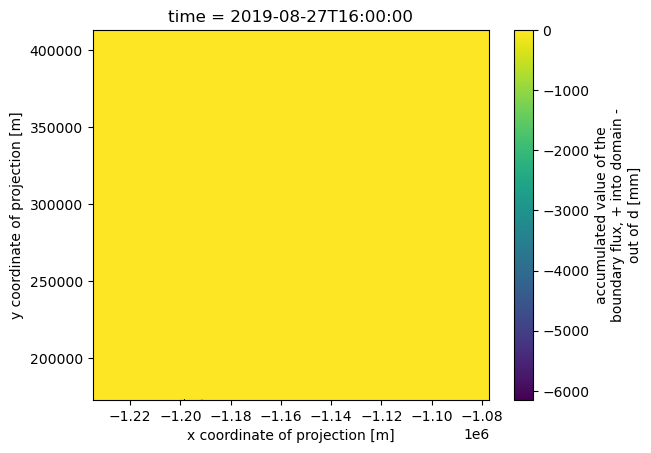

In [40]:
ds['QBDRYRT'].plot()

Next, we can try various chunking schemes. We will try varying temporal and spatial dimensions. We will always use squares for spatial dimensions as we cannot assume that latitude would be more beneficial than longituude in use cases. First, let us test with chunks across time.

Lets now define a function that can take the files, load them in zarr, and run some testcases on them

In [9]:
NUM_REPETITIONS = 5

def GetTestTime(datatset, testcases) -> int:
  times = []

  for func in testcases:
    printGreen(f"\t\tTest case: {func['name']}")
    timetoadd = 0
    startTime = time.time()

    for i in range(NUM_REPETITIONS):
      func['func'](datatset)
      
    endTime = time.time()
    timetoadd += endTime - startTime
    timetoadd = timetoadd / NUM_REPETITIONS

    times.append(timetoadd)
    
  return times

def RunTestCases(pictureName, testcases, chunkSchemes) -> None:
  printHeader("Running benchmark test cases")
  times = []

  for file in os.listdir(f"/anvil/scratch/{USERNAME}/"):
    fullpath = os.path.join(f"/anvil/scratch/{USERNAME}/", file)
    printGreen(f"\tTesting scheme: {file[:-5]}")
    ds = xr.open_zarr(fullpath)
    times.append(GetTestTime(ds, testcases))

  times = np.array(times)

  for idx, func in enumerate(testcases):
    plt.figure(figsize=(12, 6))

    # Create a line plot
    plt.plot([scheme['name'] for scheme in chunkSchemes], times[:, idx])

    # Add labels and title
    plt.xlabel('Chunk Size')
    plt.ylabel(f'Time for test case')
    plt.title(f'{testcases[idx]['name']}')

    # Save the chart to a file (e.g., as a PNG image)
    plt.savefig(f'{testcases[idx]['name']}_{pictureName}.png')

    # avoid overlap
    plt.close()

def Rechunk(chunkSchemes) -> None:
  printHeader("Attempting to re-chunk dataset")

  rrt = None
  for idx, scheme in enumerate(chunkSchemes):
    if not os.path.exists(f"/anvil/scratch/{USERNAME}/{scheme['name']}.zarr"):

      if rrt is None:
        printRed("Missing scheme found! Loading entire dataset...")
        ds = xr.open_mfdataset("/anvil/projects/x-cis220065/x-cybergis/compute/AORC_Forcing/2016/*.LDASIN_DOMAIN1", engine = "netcdf4", combine= "nested", concat_dim="Time", parallel = "True")
        rrt = ds["RAINRATE"]

      printGreen(f"Re-chunking using scheme {scheme['name']}")

      rrt = rrt.chunk(scheme['scheme'])
      rrt.to_zarr(f"/anvil/scratch/{USERNAME}/{scheme['name']}.zarr", mode="w")
  


In [10]:
# Test Cases
def Bench_MaxRain(datatset: xr.Dataset):
  datatset['RAINRATE'].max().values.compute()

def Bench_Average_200sqr(datatset: xr.Dataset):
  area = datatset.sel(south_north=slice(200, 400), west_east=slice(200,400))
  area['RAINRATE'].mean(dim="Time").values.compute()

def Bench_Average_400sqr(datatset: xr.Dataset):
  area = datatset.sel(south_north=slice(000, 400), west_east=slice(000,400))
  area['RAINRATE'].mean(dim="Time").values.compute()

def Bench_Average_800sqr(datatset: xr.Dataset):
  area = datatset.sel(south_north=slice(000, 800), west_east=slice(000,800))
  area['RAINRATE'].mean(dim="Time").values.compute()

def Bench_Average_1600sqr(datatset: xr.Dataset):
  area = datatset.sel(south_north=slice(000, 1600), west_east=slice(000,1600))
  area['RAINRATE'].mean(dim="Time").values.compute()

testcases = [
  {'name': 'Max_Rain_Test', 'func': Bench_MaxRain},
  {'name': 'Average_200_sqr', 'func': Bench_Average_200sqr},
  {'name': 'Average_400_sqr', 'func': Bench_Average_400sqr},
  {'name': 'Average_800_sqr', 'func': Bench_Average_800sqr},
  {'name': 'Average_1600_sqr', 'func': Bench_Average_1600sqr},
  ]


In [11]:
# Test chunk schemes across time
chunkSchemes = [
  {'name': "1x1x1", 'scheme': {"Time": 1, "south_north": 100, "west_east": 100}},
  {'name': "50x300x300", 'scheme': {"Time": 50, "south_north": 300, "west_east": 300}},
  {'name': "100x600x600", 'scheme': {"Time": 100, "south_north": 600, "west_east": 600}},
  {'name': "150x900x900", 'scheme': {"Time": 150, "south_north": 900, "west_east": 900}},
  {'name': "200x1200x1200", 'scheme': {"Time": 200, "south_north": 1200, "west_east": 1200}},
  {'name': "250x1500x1500", 'scheme': {"Time": 250, "south_north": 1500, "west_east": 1500}},
  {'name': "300x1800x1800", 'scheme': {"Time": 300, "south_north": 1800, "west_east": 1800}},
  ]

Rechunk(chunkSchemes)

RunTestCases("chunk_test", testcases, chunkSchemes)

Attempting to re-chunk dataset
Missing scheme found! Loading entire dataset...
Re-chunking using scheme 1x1x1


KeyboardInterrupt: 